In [29]:
import cv2
import numpy as np
import pandas as pd
import heapq
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

from collections import defaultdict

Compression Ratio (ρ): 0.8913549913194444
MSE1:0.0,MSE2:0.0
SCORE:178.27099826388888


(np.float64(0.0), 0.8913549913194444, np.float64(178.27099826388888))

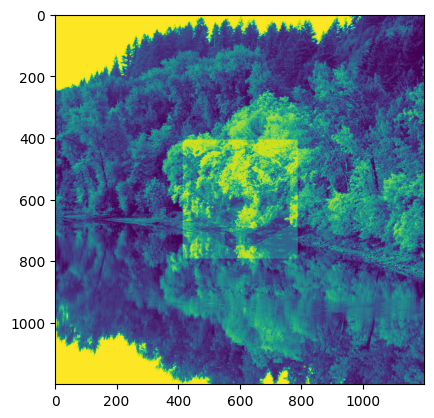

In [30]:


# Step 2: Calculate frequency of each pixel intensity
def calculate_frequency(image):
    frequency = defaultdict(int)
    for pixel in image.ravel():
        frequency[pixel] += 1
    return frequency

# Step 3: Create a Huffman Tree
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None
    
    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequency):
    priority_queue = [HuffmanNode(value, freq) for value, freq in frequency.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        
        internal_node = HuffmanNode(None, left.frequency + right.frequency)
        internal_node.left = left
        internal_node.right = right
        
        heapq.heappush(priority_queue, internal_node)

    return priority_queue[0]  # Root of the tree

# Step 4: Generate Huffman Codes
def generate_huffman_codes(node, current_code='', codes=defaultdict(str)):
    if node is not None:
        if node.value is not None:
            codes[node.value] = current_code
        generate_huffman_codes(node.left, current_code + '0', codes)
        generate_huffman_codes(node.right, current_code + '1', codes)
    return codes

# Step 5: Compress Image Using Huffman Coding
def compress_image(image, huffman_codes):
    compressed_data = ''
    for pixel in image.ravel():
        compressed_data += huffman_codes[pixel]
    return compressed_data

# Step 6: Decompress Image
def decompress_image(compressed_data, huffman_tree, original_shape):
    current_node = huffman_tree
    decompressed_image = []

    for bit in compressed_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.value is not None:
            decompressed_image.append(current_node.value)
            current_node = huffman_tree  # Reset to root

    return np.array(decompressed_image).reshape(original_shape)

def calculate_metrics(original_image1, reconstructed_image1, bitstream1,
                      original_image2, reconstructed_image2, bitstream2):
    # Calculate MSE for both images
    mse1 = np.mean((original_image1 - reconstructed_image1) ** 2)
    mse2 = np.mean((original_image2 - reconstructed_image2) ** 2)
    SUM = mse1 + mse2
    
    # Calculate compression ratio (ρ)
    total_bits_original = 2 * 1200 * 1200 * 8
    total_bits_compressed = len(bitstream1)+len(bitstream2)
    rho = total_bits_compressed / total_bits_original
    
    # Combined score
    score = SUM + (200 * rho)
    
    # print(f"Compressed Bits (Image1): {sum(len(chunk) for chunk in bitstream1)}")
    # print(f"Compressed Bits (Image2): {sum(len(chunk) for chunk in bitstream2)}")
    # print(f"Original Bits: {total_bits_original}")
    print(f"Compression Ratio (ρ): {rho}")
    print(f"MSE1:{mse1},MSE2:{mse2}")
    print(f"SCORE:{score}")
    return SUM, rho, score

def process(image_path):
# Step 1: Read the image

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    frequency = calculate_frequency(image)

    # Build Huffman Tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman codes
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Compress the image using the generated Huffman codes
    compressed_data = compress_image(image, huffman_codes)

    # To visualize the compression
    compressed_size = len(compressed_data)
    original_size = image.size * 8  # in bits (assuming 8-bit grayscale)

    # print(f'Original image size: {original_size} bits')
    # print(f'Compressed image size: {compressed_size} bits')

    # Step 8: Decompress and reconstruct the image
    decompressed_image = decompress_image(compressed_data, huffman_tree, image.shape)


    # Display the original and decompressed images
    plt.imshow(decompressed_image)
    return compressed_data,decompressed_image

c1,r1=process('Watermarked_Image1.tiff')
c2,r2=process('Watermarked_Image2.tiff')
og1,og2 =cv2.imread('Watermarked_Image1.tiff', cv2.IMREAD_GRAYSCALE),  cv2.imread('Watermarked_Image2.tiff', cv2.IMREAD_GRAYSCALE)


calculate_metrics(og1,r1,c1,og2,r2,c2)




In [31]:
def group(compressed_data):
    byte_data = []
    for i in range(0, len(compressed_data), 8):
        byte_data.append(compressed_data[i:i+8])
    return byte_data

bitstreamimage1=group(c1)
bitstreamimage2=group(c2)
size1=1200*1200-len(bitstreamimage1)
size2=1200*1200-len(bitstreamimage2)


submission = pd.DataFrame({
"ID": list(range(1200*1200)),
"CompressedImage1": np.array(bitstreamimage1+(["I"]*size1)),
    "CompressedImage2":  np.array(bitstreamimage2+(["I"]*size2)),
    "Image1": np.array(r1).flatten(),
    "Image2": np.array(r2).flatten(),} )

submission.to_csv("submission.csv", index=False)

